## Utilizing a LLM to interpret and describe images provided. 

This notebook is a simple example of how to use a Multimodal LLM to interpret and describe images. Intentionally added random imgas from the internet and gave them a random file name to see how the model would interpret them and not to give any hints to the model.

<div class="alert alert-block alert-info">
<b>Tip:</b> Recommend to run the code cells in order to see the output of the endpoints and understand the examples provided. 
</div>

<div class="alert alert-block alert-warning">
<b>Note:</b> All credential information and API keys are removed from the code cells and declared as environment variables for security purposes. We recommend to do the same when running the code cells if you are sharing the notebook.
</div>

<div class="alert alert-block alert-warning">
<b>Note:</b> If you plan on using this code for your own images, please make sure to select the appropriate persona, define the new image paths, and make any necessary changes to the prompt. 
</div>



## Import Libraries and Set Environment Variables 

Let's start by importing the necessary libraries and setting the environment variables.

> There will be more detail within this notebook than what is relevant to the user, but it is important to understand the different endpoints and what they represent. Also, note that the code is not being written in a production-ready manner, but rather to demonstrate the different endpoints and their outputs.

In [1]:
import json # Import the json module to work with JSON data
import requests # Import the requests library to send HTTP requests
from asksageclient import AskSageClient # Import the AskSageClient class from the asksageclient module
import pandas as pd # Import the pandas library to work with dataframes
from PIL import Image
import matplotlib.pyplot as plt
import os # Import the os module to interact with the operating system

# Function to load credentials from a JSON file
def load_credentials(filename):
    try:
        with open(filename) as file:
            return json.load(file)
    except FileNotFoundError:
        raise FileNotFoundError("The credentials file was not found.")
    except json.JSONDecodeError:
        raise ValueError("Failed to decode JSON from the credentials file.")

# Load the credentials
credentials = load_credentials('../../credentials.json')

# Extract the API key, and email from the credentials to be used in the API request
api_key = credentials['credentials']['api_key']
email = credentials['credentials']['Ask_sage_user_info']['username']


## Interact with the AskSage Python API Client

The AskSage Python API Client provides a simple way to interact with the AskSage API. The client provides methods for each endpoint, making it easy to use the API without having to deal with more time-consuming tasks like making HTTP requests and handling responses.

First order is defining the client and setting the credentials for the client, which are the email and API key.

In [2]:
"""  
class AskSageClient(
    email: email, # The email address of the user
    api_key: api_key, # The API key for the AskSage API, which can be obtained from the AskSage website
    user_base_url: str = 'https://api.asksage.ai/user', # The base URL for the user API
    server_base_url: str = 'https://api.asksage.ai/server' # The base URL for the server API
)
"""

ask_sage_client = AskSageClient(email, api_key) # Create an instance of the AskSageClient class with the email and api_key 

In [3]:
get_personas = ask_sage_client.get_personas() # Get the personas using the get_personas endpoint

## Get a dataframe with all ther personas and their respective 'ID'

# extract relevant information from the response 'id', 'name' and 'description'
def extract_personas(response):
    return [{'id': persona['id'], 'name': persona['name'], 'description': persona['description']} for persona in response['response']]

personas = extract_personas(get_personas) # Extract the personas using the extract_personas function

# Putting all information into a dataframe and set id as index
personas_df = pd.DataFrame(personas).set_index('id')

# set column width to display full content
pd.set_option('display.max_colwidth', None)

display(personas_df.head()) # remove .head() to display all personas

,name,description
id,,
1,Ask Sage,"Use this persona when you need a general-purpose AI that can handle a wide range of tasks, from translating languages to writing essays and code."
2,Legal Assistant,Use this persona when you need legal advice or information. This persona can provide accurate and helpful advice on a wide range of legal topics.
3,Contracting Officer,"Use this persona when you have questions or need advice about government contracts, Federal Acquisition Regulation (FAR) regulations, the Defense Federal Acquisition Regulation Supplement (DFARS) regulations and acquisition related questions."
4,Software Developer,"Use this persona when you need to write, review, or debug code. This persona can also provide advice on software development best practices and security standards."
5,ISSO (Cyber),Use this persona when you need advice or information about cybersecurity requirements and issues. This persona can provide accurate and helpful advice on a wide range of cybersecurity topics.


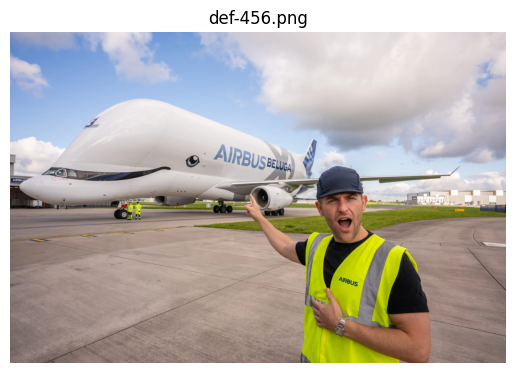

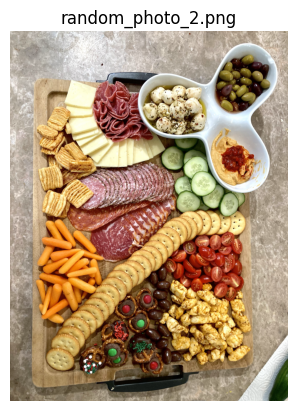

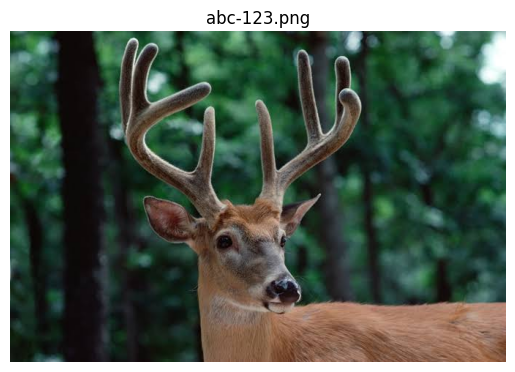

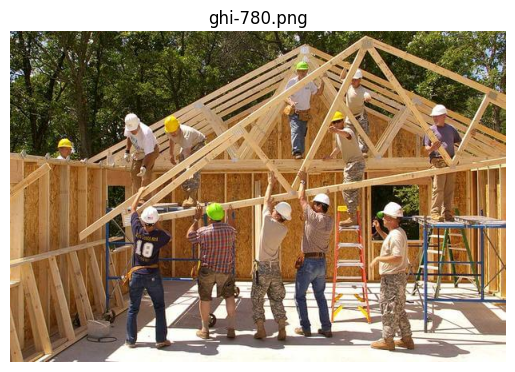

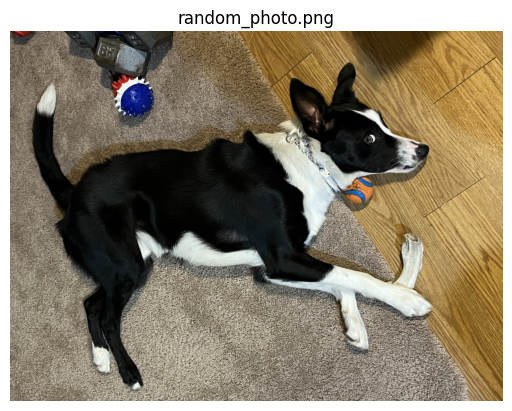

In [4]:
file_path = 'ex-images/'  # Update with your file path

def render_images(file_path):
    files = os.listdir(file_path)
    for file in files[:5]:
        img = Image.open(file_path + file)
        plt.title(file)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

render_images(file_path)

In [ ]:
def query_with_file_loop(file_path):
    """
    Queries the AskSage API with files from a directory.

    Args:
        file_path (str): The path to the directory containing the files.

    Returns:
        dict: A dictionary containing the API responses for each file.
    """
    files = os.listdir(file_path)
    response = {}

    # Process the first 5 files
    for file in files[:5]:
        full_path = os.path.join(file_path, file)
        message = f'Tell me what is in the photo provide a detailed response {full_path}'  # Your question/prompt
        persona = 1  # The persona you want to use, provide the ID of the persona
        model = 'gpt-4o-mini'

        try:
            # Ensure ask_sage_client.query_with_file properly sanitizes inputs and handles outputs to prevent injections
            api_response = ask_sage_client.query_with_file(message, full_path, persona, model, limit_references=0)
            response[file] = api_response  # Store the entire API response
        except Exception as e:
            print(f"Error querying file {file}: {e}")
            response[file] = {'message': 'Error occurred'}

    return response


def extract_clean_message(data):
    """
    Extracts and cleans the message content from the API responses.

    Args:
        data (dict): A dictionary containing the API responses.

    Returns:
        pandas.DataFrame: A DataFrame containing the cleaned message content.
    """
    empty_list = []
    for key, value in data.items():
        try:
            # Safely access the 'message' key
            message = value.get('message', '')

            # Check if the message is empty or None to avoid errors
            if not message:
                print(f"Warning: Message is empty for file {key}")
                empty_list.append('Message is empty')
                continue

            # Define the prefix to remove
            prefix = "}}"

            # Find the index of the prefix
            prefix_index = message.find(prefix)

            # If the prefix is found, extract the content after it
            if prefix_index != -1:
                content = message[prefix_index + len(prefix):].strip()
            else:
                print(f"Warning: Prefix not found in message for file {key}")
                content = message  # If prefix not found, use the original message

            empty_list.append(content)

        except Exception as e:
            print(f"Error processing file {key}: {e}")
            empty_list.append('Error processing content')
            print(f"Raw response: {value}")  # Print the raw response for debugging

    # Create a DataFrame with the list of content
    df = pd.DataFrame(empty_list, columns=['content'])

    # Clean the content in the DataFrame
    df['content'] = df['content'].str.replace('\n', '', regex=False)  # Remove any '\n'
    df['content'] = df['content'].str.replace('.', '. ', regex=False)  # Add space after periods

    # Set the index to the file names
    df.index = data.keys()

    return df


# Example usage (assuming file_path and ask_sage_client are defined)
file_path = 'ex-images/'  # Update with your file path
response = query_with_file_loop(file_path)
df = extract_clean_message(response)
display(df)

content
def-456.png                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      The image features an Airbus Beluga cargo plane on the tarmac under a partly cloudy sky.  The aircraft is predominantly white with the word "AIRBUS" and the model name "BELUGA" emblazoned on its side in large, bold letters.  The plane's design is distinctive, with an oversized, bulbous fuselage that tapers towards the rear, resembling the shape of a beluga whale, which is where it gets its name.  This design allows for the transport of large cargo items. In the foreground, a person wearing a high-visibility vest with the "AIRBUS" logo is standing with their left hand raised, pointing towards the aircraft.  The individual appears to be wearing a dark cap and a watch on their left wrist.  The setting suggests an airport environment, with various airport buildings and infrastructure visible in the background.  The ground is marked with tarmac lines, indicating a designated area for aircraft movement.  The overall scene captures a moment of ground operations involving the unique Airbus Beluga cargo plane. </file-content>Based on the description provided, the image in the file "def-456. png" features an Airbus Beluga cargo plane on the tarmac of an airport.  Here is a detailed breakdown of the contents of the image:- **Aircraft**: The main focus of the image is the Airbus Beluga cargo plane.  It is predominantly white in color with the prominent "AIRBUS" and "BELUGA" markings on its side.  The design of the aircraft is unique, with a large, bulbous fuselage that narrows towards the rear, resembling the shape of a beluga whale.  This design allows the aircraft to transport large cargo items. - **Person**: In the foreground of the image, there is a person wearing a high-visibility vest with the "AIRBUS" logo.  The individual is standing with their left hand raised, pointing towards the aircraft.  They are also wearing a dark cap and a watch on their left wrist. - **Environment**: The background of the image depicts an airport environment.  Various airport buildings and infrastructure are visible, indicating that the scene is set on an airport tarmac.  The ground is marked with tarmac lines, showing designated areas for aircraft movement. Overall, the image captures a moment of ground operations involving the unique Airbus Beluga c